Epoch 1/700 - Train Loss: 0.0099 - Val Loss: 0.0037
Epoch 2/700 - Train Loss: 0.0043 - Val Loss: 0.0029
Epoch 3/700 - Train Loss: 0.0033 - Val Loss: 0.0028
Epoch 4/700 - Train Loss: 0.0031 - Val Loss: 0.0027
Epoch 5/700 - Train Loss: 0.0028 - Val Loss: 0.0026
Epoch 6/700 - Train Loss: 0.0028 - Val Loss: 0.0026
Epoch 7/700 - Train Loss: 0.0026 - Val Loss: 0.0028
Epoch 8/700 - Train Loss: 0.0028 - Val Loss: 0.0024
Epoch 9/700 - Train Loss: 0.0026 - Val Loss: 0.0026
Epoch 10/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 11/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 12/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 13/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 14/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 15/700 - Train Loss: 0.0024 - Val Loss: 0.0027
Epoch 16/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 17/700 - Train Loss: 0.0025 - Val Loss: 0.0028
Epoch 18/700 - Train Loss: 0.0024 - Val Loss: 0.0024
Epoch 19/700 - Train Loss: 0.0024 - Val Loss: 0.0025
Ep

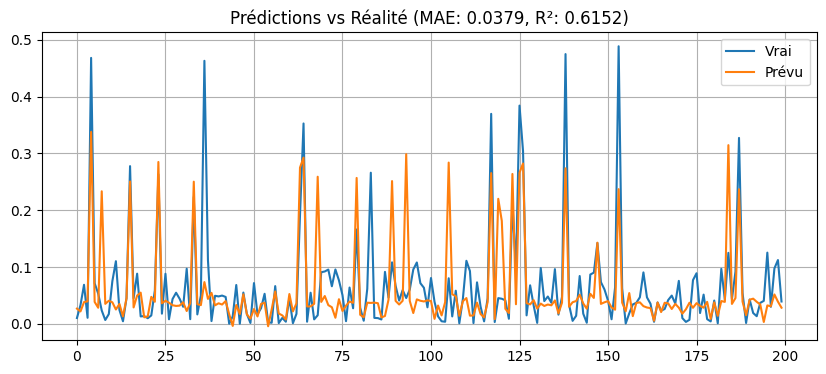

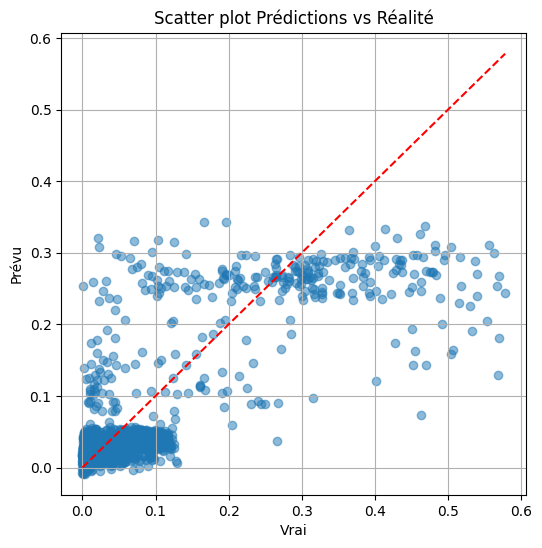

In [1]:
# 📚 Imports
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 📁 Chargement du jeu de données
raw_df = pd.read_csv("scaled_dataset.csv")

# ✅ Normalisation de la cible (juste au cas où)
scaler_y = MinMaxScaler()
raw_df['production'] = scaler_y.fit_transform(raw_df[['production']])

# 🔄 Séquences temporelles
window_size = 48  # fenêtre de 2 jours horaires

def create_sequences(data, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(raw_df, 'production')

# 📎 Split Train/Val/Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 📦 Dataset PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

# 🔧 Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# 🧠 Transformer amélioré (version allégée)
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=2, num_layers=1, dim_feedforward=64, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, src):
        x = self.input_linear(src)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.regressor(x)

# ⚙️ Entraînement avec EarlyStopping et validation
model = TransformerRegressor(input_dim=X_train.shape[2])
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

n_epochs = 700
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping déclenché")
            break

# 📊 Évaluation finale
model.eval()
preds, truths = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb).cpu().numpy()
        preds.extend(pred)
        truths.extend(yb.numpy())

preds = np.array(preds).flatten()
truths = np.array(truths).flatten()

mae = mean_absolute_error(truths, preds)
r2 = r2_score(truths, preds)

print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10,4))
plt.plot(truths[:200], label="Vrai")
plt.plot(preds[:200], label="Prévu")
plt.legend()
plt.title(f"Prédictions vs Réalité (MAE: {mae:.4f}, R²: {r2:.4f})")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(truths, preds, alpha=0.5)
plt.plot([truths.min(), truths.max()], [truths.min(), truths.max()], 'r--')
plt.xlabel("Vrai")
plt.ylabel("Prévu")
plt.title("Scatter plot Prédictions vs Réalité")
plt.grid(True)
plt.show()

Epoch 1/700 - Train Loss: 0.0099 - Val Loss: 0.0027
Epoch 2/700 - Train Loss: 0.0034 - Val Loss: 0.0025
Epoch 3/700 - Train Loss: 0.0030 - Val Loss: 0.0024
Epoch 4/700 - Train Loss: 0.0029 - Val Loss: 0.0027
Epoch 5/700 - Train Loss: 0.0027 - Val Loss: 0.0025
Epoch 6/700 - Train Loss: 0.0028 - Val Loss: 0.0023
Epoch 7/700 - Train Loss: 0.0028 - Val Loss: 0.0025
Epoch 8/700 - Train Loss: 0.0026 - Val Loss: 0.0026
Epoch 9/700 - Train Loss: 0.0026 - Val Loss: 0.0023
Epoch 10/700 - Train Loss: 0.0024 - Val Loss: 0.0021
Epoch 11/700 - Train Loss: 0.0025 - Val Loss: 0.0023
Epoch 12/700 - Train Loss: 0.0025 - Val Loss: 0.0021
Epoch 13/700 - Train Loss: 0.0024 - Val Loss: 0.0022
Epoch 14/700 - Train Loss: 0.0024 - Val Loss: 0.0021
Epoch 15/700 - Train Loss: 0.0023 - Val Loss: 0.0020
Epoch 16/700 - Train Loss: 0.0023 - Val Loss: 0.0021
Epoch 17/700 - Train Loss: 0.0023 - Val Loss: 0.0023
Epoch 18/700 - Train Loss: 0.0023 - Val Loss: 0.0021
Epoch 19/700 - Train Loss: 0.0023 - Val Loss: 0.0021
Ep

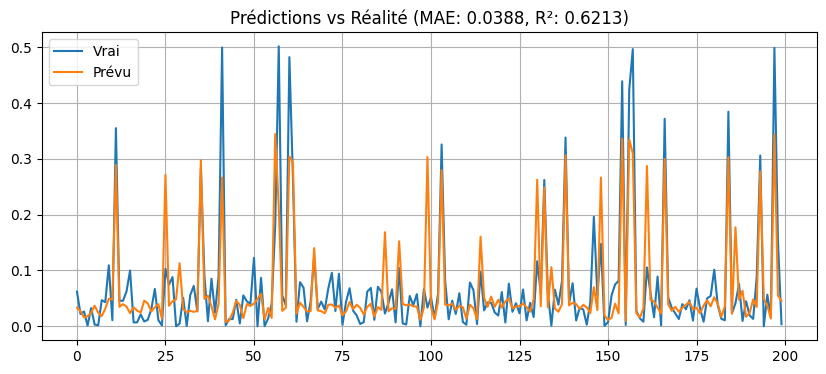

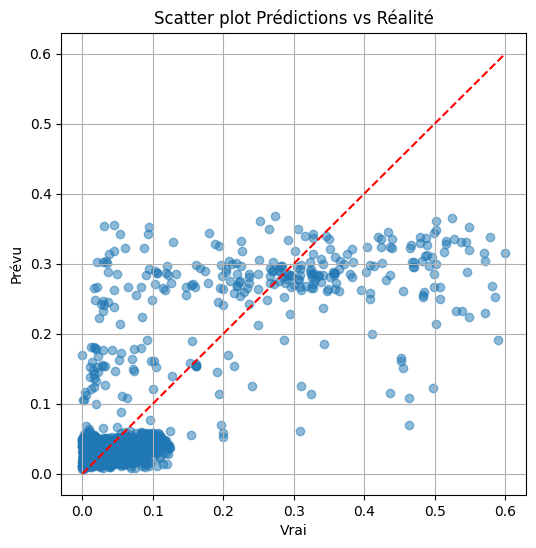

In [2]:
# 📚 Imports
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 📁 Chargement du jeu de données
# === 1. Chargement des données ===
df = pd.read_csv("full_dataset.csv",sep=";")  # Remplace par ton CSV réel
# 1.1 Conversion de la colonne date
df['date1'] = pd.to_datetime(df['date'], dayfirst=True)

# 1.2 Création des features temporelles cycliques
df['dayofweek'] = df['date1'].dt.dayofweek
df['month'] = df['date1'].dt.month

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df.drop(columns=['month', 'dayofweek'], inplace=True)

# 1.3 Supprimer les colonnes non numériques avant normalisation
df = df.select_dtypes(include=[np.number])

# ✅ Normalisation de la cible (juste au cas où)
scaler_y = MinMaxScaler()
df['production'] = scaler_y.fit_transform(df[['production']])

# 🔄 Séquences temporelles
window_size = 48  # fenêtre de 2 jours horaires

def create_sequences(data, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(df, 'production')

# 📎 Split Train/Val/Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 📦 Dataset PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

# 🔧 Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# 🧠 Transformer amélioré (version allégée)
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=2, num_layers=1, dim_feedforward=64, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, src):
        x = self.input_linear(src)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.regressor(x)

# ⚙️ Entraînement avec EarlyStopping et validation
model = TransformerRegressor(input_dim=X_train.shape[2])
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

n_epochs = 700
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping déclenché")
            break

# 📊 Évaluation finale
model.eval()
preds, truths = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb).cpu().numpy()
        preds.extend(pred)
        truths.extend(yb.numpy())

preds = np.array(preds).flatten()
truths = np.array(truths).flatten()

mae = mean_absolute_error(truths, preds)
r2 = r2_score(truths, preds)

print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10,4))
plt.plot(truths[:200], label="Vrai")
plt.plot(preds[:200], label="Prévu")
plt.legend()
plt.title(f"Prédictions vs Réalité (MAE: {mae:.4f}, R²: {r2:.4f})")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(truths, preds, alpha=0.5)
plt.plot([truths.min(), truths.max()], [truths.min(), truths.max()], 'r--')
plt.xlabel("Vrai")
plt.ylabel("Prévu")
plt.title("Scatter plot Prédictions vs Réalité")
plt.grid(True)
plt.show()